In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import properscoring as ps
import scipy.stats as st

import gc as garbage

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
#%load_ext line_profiler

In [2]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
def mean_average_percentage_error(y_true, y_pred):
    return np.nanmean(np.abs((y_true - y_pred) / y_true))*100.

In [4]:
garbage.collect()

11

# Load dataset

In [5]:
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('scikit-learn', sklearn.__version__)


numpy 1.14.5
pandas 0.23.4
scikit-learn 0.19.2


In [ ]:
!curl https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip

In [ ]:
!unzip household_power_consumption.zip

In [6]:
fname = './household_power_consumption.txt'
df = pd.read_csv(fname, sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [7]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [8]:
ts = df.Global_active_power.resample('1h').mean()

hourly_m = ts.groupby(ts.index.hour).mean()
hourly_50 = ts.groupby(ts.index.hour).quantile(0.50)
hourly_25 = ts.groupby(ts.index.hour).quantile(0.25)
hourly_75 = ts.groupby(ts.index.hour).quantile(0.75)
hourly_05 = ts.groupby(ts.index.hour).quantile(0.05)
hourly_95 = ts.groupby(ts.index.hour).quantile(0.95)

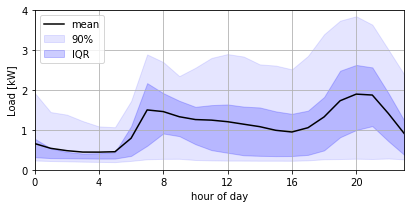

In [9]:
plt.figure(figsize=(6,3))
plt.fill_between(hourly_m.index, hourly_05, hourly_95, alpha=0.1, color='blue', label='90%')
plt.fill_between(hourly_m.index, hourly_25, hourly_75, alpha=0.2, color='blue', label='IQR')
plt.plot(hourly_m, label='mean', color='k', linestyle='solid')
#plt.plot(hourly_50, label='median', color='k', linestyle='dashed')
plt.ylabel('Load [kW]')
plt.xlabel('hour of day')
plt.grid(True)
plt.xticks(np.arange(0, 24, step=4))
plt.xlim(0,23)
plt.ylim(0,4)
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig('hourly.png', dpi=300)

In [10]:
ts = df.Global_active_power.resample('1d').mean()

daily_m = ts.groupby(ts.index.dayofweek).mean()
daily_50 = ts.groupby(ts.index.dayofweek).quantile(0.50)
daily_25 = ts.groupby(ts.index.dayofweek).quantile(0.25)
daily_75 = ts.groupby(ts.index.dayofweek).quantile(0.75)
daily_05 = ts.groupby(ts.index.dayofweek).quantile(0.05)
daily_95 = ts.groupby(ts.index.dayofweek).quantile(0.95)

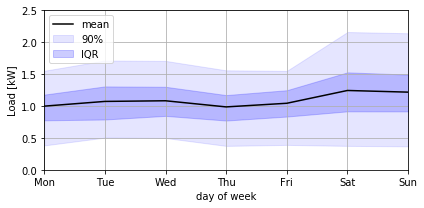

In [11]:
plt.figure(figsize=(6,3))
plt.fill_between(daily_m.index, daily_05, daily_95, alpha=0.1, color='blue', label='90%')
plt.fill_between(daily_m.index, daily_25, daily_75, alpha=0.2, color='blue', label='IQR')
plt.plot(daily_m, label='mean', color='k', linestyle='solid')
#plt.plot(daily_50, label='median', color='k', linestyle='dashed')
plt.ylabel('Load [kW]')
plt.xlabel('day of week')
plt.xticks(np.arange(7),('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'))
plt.grid(True)
plt.xlim(0,6)
plt.ylim(0,2.5)
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig('daily.png', dpi=300)

In [12]:
ts = df.Global_active_power.resample('1w').mean()

weekly_m = ts.groupby(ts.index.weekofyear).mean()
weekly_50 = ts.groupby(ts.index.weekofyear).quantile(0.50)
weekly_25 = ts.groupby(ts.index.weekofyear).quantile(0.25)
weekly_75 = ts.groupby(ts.index.weekofyear).quantile(0.75)
weekly_05 = ts.groupby(ts.index.weekofyear).quantile(0.05)
weekly_95 = ts.groupby(ts.index.weekofyear).quantile(0.95)
weekly_m.index -= 1

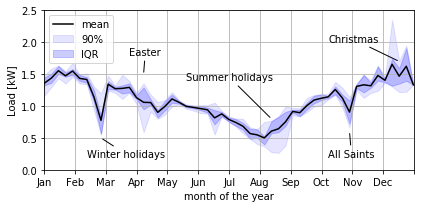

In [13]:
plt.figure(figsize=(6,3))
plt.fill_between(weekly_m.index, weekly_05, weekly_95, alpha=0.1, color='blue', label='90%')
plt.fill_between(weekly_m.index, weekly_25, weekly_75, alpha=0.2, color='blue', label='IQR')
plt.plot(weekly_m, label='mean', color='k', linestyle='solid')
#plt.plot(daily_50, label='median', color='k', linestyle='dashed')
plt.ylabel('Load [kW]')
plt.xlabel('month of the year')
plt.grid(True)
plt.xticks(np.arange(0,53,4.34),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.annotate('Winter holidays', xy=(8, 0.5), xytext=(6, 0.2),
             arrowprops={'arrowstyle':'-'})
plt.annotate('Easter', xy=(14, 1.5), xytext=(12, 1.8),
             arrowprops={'arrowstyle':'-'})
plt.annotate('Summer holidays', xy=(32, 0.8), xytext=(20, 1.4),
             arrowprops={'arrowstyle':'-'})
plt.annotate('All Saints', xy=(43, 0.6), xytext=(40, 0.2),
             arrowprops={'arrowstyle':'-'})
plt.annotate('Christmas', xy=(50, 1.7), xytext=(40, 2),
             arrowprops={'arrowstyle':'-'})
plt.xlim(0,52.1)
plt.ylim(0,2.5)
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig('weekly.png', dpi=300)

In [14]:
df.Global_active_power.resample('1T').mean().describe()

count    2.049280e+06
mean     1.091615e+00
std      1.057294e+00
min      7.600000e-02
25%      3.080000e-01
50%      6.020000e-01
75%      1.528000e+00
max      1.112200e+01
Name: Global_active_power, dtype: float64

In [15]:
2.049280e+06 / 2.049280e+06

1.0

In [16]:
df.Global_active_power.resample('15min').mean().describe()

count    136639.000000
mean          1.091678
std           0.991206
min           0.078000
25%           0.321333
50%           0.654800
75%           1.562533
max           8.566133
Name: Global_active_power, dtype: float64

In [17]:
df.Global_active_power.resample('1h').mean().describe()

count    34168.000000
mean         1.091728
std          0.897619
min          0.124000
25%          0.341925
50%          0.802850
75%          1.579342
max          6.560533
Name: Global_active_power, dtype: float64

In [18]:
df.Global_active_power.resample('1d').mean().describe()

count    1433.000000
mean        1.092048
std         0.420415
min         0.173818
25%         0.816776
50%         1.080732
75%         1.323926
max         3.314851
Name: Global_active_power, dtype: float64

In [19]:
df.Global_active_power.resample('1w').mean().describe()

count    207.000000
mean       1.095757
std        0.336632
min        0.183998
25%        0.877657
50%        1.098516
75%        1.328998
max        2.505248
Name: Global_active_power, dtype: float64

In [20]:
df.fillna(df.shift(7, freq='d'), inplace=True)
df.fillna(method='pad', inplace=True)
print(df.isnull().sum())

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


In [21]:
(1. - 2.049280e+06 / df.shape[0]) * 100

1.2518437457685994

In [22]:
train_date = pd.Timestamp('01-01-2009')
test_date = pd.Timestamp('01-01-2010')

In [23]:
def long_term_fit(ts):
    y = ts
    
    year = y.index.year.to_series(name='year', index=y.index)
    dayofyear = y.index.dayofyear.to_series(name='dayofyear', index=y.index)
    month = y.index.month.to_series(name='month', index=y.index)
    dayofweek = y.index.dayofweek.to_series(name='dayofweek', index=y.index)
    hour = y.index.hour.to_series(name='hour', index=y.index)
    minute = y.index.minute.to_series(name='minute', index=y.index)
    time = hour + minute / 60.
    time.name = 'hour'
    
    X = pd.concat([year, dayofyear, dayofweek, time], axis=1)

    print('Find optimal tree depth...')
    depth = 0
    rmse_val = np.inf
    for d in range(8, 11):
        print('Depth: %d'%d)
        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True, 
                                   max_features='sqrt', max_depth=d, random_state=42)

        rf.fit(X[:train_date], y[:train_date])
        rmse = root_mean_squared_error(rf.predict(X[train_date:test_date]), 
                                       y[train_date:test_date])
        if (rmse < rmse_val):
            rmse_val = rmse
            depth = d
    print('MAX_DEPTH: %d - RMSE_VAL %f' %(depth, rmse_val))
    
    print('Fit random forest...')
    
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True, 
                               max_features='sqrt', max_depth=depth, random_state=42)

    rf.fit(X[:test_date], y[:test_date])
    
    rmse_train = root_mean_squared_error(rf.predict(X[:test_date]), y[:test_date])
    rmse_test = root_mean_squared_error(rf.predict(X[test_date:]), y[test_date:])
    print('RMSE_TRAIN: %f - RMSE_TEST %f' %(rmse_train, rmse_test))
    
    return rf

In [24]:
def long_term_predict(dt, rf):
    year = dt.year.to_series(name='year', index=dt)
    dayofyear = dt.dayofyear.to_series(name='dayofyear', index=dt)
    month = dt.month.to_series(name='month', index=dt)
    dayofweek = dt.dayofweek.to_series(name='dayofweek', index=dt)
    hour = dt.hour.to_series(name='hour', index=dt)
    minute = dt.minute.to_series(name='minute', index=dt)
    time = hour + minute / 60.
    time.name = 'hour'
    
    X = pd.concat([year, dayofyear, dayofweek, time], axis=1)
    
    ts_lt = pd.Series(rf.predict(X), index=dt)
    
    return ts_lt

In [25]:
def short_term_fit(ts, ts_lt, lookback, steps):
    ts_ref = ts_lt.reindex_like(ts)

    res = ts - ts_ref
    
    Xy = pd.concat([res.shift(-h) for h in range(-lookback+1, steps+1)], axis=1).dropna()
    Xy.columns = range(-lookback+1, steps+1)
    X = Xy.loc[:,:0]
    y = Xy.loc[:,1:]
    
    print('Fit Linear regression...')

    lr = LinearRegression(n_jobs=-1)
    
    lr.fit(X[:test_date], y[:test_date])
    
    return lr

In [26]:
def short_term_predict(ts, ts_lt, lr, lookback, steps):
    ts_ref = ts_lt.reindex_like(ts)

    res = ts - ts_ref
    
    X = pd.concat([res.shift(-h) for h in range(-lookback+1, 1)], axis=1).dropna()
    X.columns = range(-lookback+1, 1)

    print('Predict linear regression...')
    
    res_st = pd.DataFrame(lr.predict(X), index=X.index)
    res_st.columns = range(1, steps+1)
    
    ts_st = pd.DataFrame()
    for s in res_st.columns:
        ts_st[s] = ts_ref + res_st[s].shift(s)
    
    return ts_st

In [27]:
def short_term_single(ts, rf, lr, lookback, steps):
    t0 = ts.index[-1]
    resolution = ts.index.freq
    dt = pd.date_range(t0 + pd.Timedelta(resolution), freq=resolution, periods=steps)
    y_lt = long_term_predict(dt, rf)
    
    x = ts[-lookback:]
    res = x - long_term_predict(x.index, rf)
    y_st = y_lt + pd.Series(lr.predict(res.values.reshape(1,-1)).flatten(), index=dt)
    
    return y_st

In [28]:
def deterministic_results(ts, ts_st, ts_p, name='deterministic', x_label='forecast time [min]', x_factor = 1):
    y_hat = ts_p[test_date:].dropna()
    y_gt = ts.reindex_like(y_hat)
    MAE_p = mean_absolute_error(y_gt, y_hat)
    MAPE_p = mean_average_percentage_error(y_gt, y_hat)
    RMSE_p = np.sqrt(mean_squared_error(y_gt, y_hat))
    
    MAE_st = []
    MAPE_st = []
    RMSE_st = []
    for s in ts_st.columns:
        y_hat = ts_st[s][test_date:].dropna()
        y_gt = ts.reindex_like(y_hat)
        MAE_st.append(mean_absolute_error(y_gt, y_hat))
        MAPE_st.append(mean_average_percentage_error(y_gt, y_hat))
        RMSE_st.append(np.sqrt(mean_squared_error(y_gt, y_hat)))
    SS_st = 1. - RMSE_st / RMSE_p
    
    print('MAE p:  %f'%MAE_p)
    print('MAPE p:  %f'%MAPE_p)
    print('RMSE p: %f'%RMSE_p)

    print()

    print('MAE:  %f - %f - %f'%(MAE_st[0], np.mean(MAE_st), MAE_st[-1]))
    print('MAPE: %f - %f - %f'%(MAPE_st[0], np.mean(MAPE_st), MAPE_st[-1]))
    print('RMSE: %f - %f - %f'%(RMSE_st[0], np.mean(RMSE_st), RMSE_st[-1]))
    print('SS:   %f - %f - %f'%(SS_st[0], np.mean(SS_st), SS_st[-1]))
    
    
    plt.figure(figsize=(4,4))
    #plt.plot(range(1, len(ts_st.columns) +1), RMSE_st, color='tab:orange', label='Deterministic', linestyle='dashed', linewidth=2)
    #plt.plot((1, len(ts_st.columns)), (RMSE_p, RMSE_p), color='tab:green', label='Persistence', linestyle='dotted', linewidth=2)
    plt.plot(np.arange(1, len(ts_st.columns) +1)*x_factor, RMSE_st, color='tab:orange', label='Deterministic', linestyle='none', marker='s')
    plt.plot(np.arange(1, len(ts_st.columns) +1)*x_factor, RMSE_p * np.ones(len(ts_st.columns)), color='tab:green', label='Persistence', linestyle='none', marker='v')
    plt.ylabel('RMSE [kW]')
    plt.xlabel(x_label)
    plt.grid(True)
    plt.xlim(0, len(ts_st.columns)*x_factor)
    #plt.ylim(0, 1.)
    plt.tight_layout()
    plt.legend(loc='lower right')
    plt.savefig(name + '.png', dpi=300)


In [29]:
def error_quantiles(ts, ts_d):
    err = ts - ts_d
    hour = err.index.hour.to_series(name='hour', index=err.index)
    eq = err.groupby(hour).quantile(np.around(np.arange(0.05, 1.0, 0.05), 3))
    return eq

In [30]:
def probabilistic_results_mean(ts, ts_st, ts_p, name='probabilistic', frac=1.0, x_label='forecast time [min]', x_factor = 1):
    crps_p = []
    crps_d = []
    crps_q = []
    
    if (frac < 1.0):
        ts_st_train = ts_st[:test_date].dropna().sample(frac=frac, random_state=42).sort_index()
    else:
        ts_st_train = ts_st[:test_date].dropna()
    
    ts_train = ts.reindex_like(ts_st_train)
    ts_p_train = ts_p.reindex_like(ts_st_train)
    
    if (frac < 1.0):
        ts_st_test = ts_st[test_date:].dropna().sample(frac=frac, random_state=42).sort_index()
    else:
        ts_st_test = ts_st[test_date:].dropna()
    
    ts_test = ts.reindex_like(ts_st_test)
    ts_p_test = ts_p.reindex_like(ts_st_test)

    for s in ts_st.columns:
        if not(s % 10):
            print(s)
        
        eq = error_quantiles(ts_train, ts_st_train[s]).unstack().values
        ts_q = np.broadcast_to(ts_st_test[s].values.reshape(-1,1), (len(ts_st_test), 19))
        h = ts_st_test.index.hour
        ts_q = (ts_q + eq[h,:]).clip(0.)
        ts_q = pd.DataFrame(ts_q, index=ts_st_test.index, columns=list(np.around(np.arange(0.05, 1.0, 0.05), 3)))
        
        crps_p.append(ps.crps_ensemble(ts_test, ts_p_test).mean())
        crps_d.append(ps.crps_ensemble(ts_test, ts_st_test[s]).mean())
        crps_q.append(ps.crps_ensemble(ts_test, ts_q).mean())
    
    print('CRPS_p:  %f - %f - %f'%(crps_p[0], np.mean(crps_p), crps_p[-1]))
    print('CRPS_d:  %f - %f - %f'%(crps_d[0], np.mean(crps_d), crps_d[-1]))
    print('CRPS_q:  %f - %f - %f'%(crps_q[0], np.mean(crps_q), crps_q[-1]))
    
    plt.figure(figsize=(4,4))
    #plt.plot(range(1, len(ts_st.columns) +1), crps_q, color='tab:blue', label='Probabilistic', linestyle='solid', linewidth=2)
    #plt.plot(range(1, len(ts_st.columns) +1), crps_d, color='tab:orange', label='Deterministic', linestyle='dashed', linewidth=2)
    #plt.plot(range(1, len(ts_st.columns) +1), crps_p, color='tab:green', label='Persistence', linestyle='dotted', linewidth=2)
    plt.plot(np.arange(1, len(ts_st.columns) +1)*x_factor, crps_q, color='tab:blue', label='Probabilistic', linestyle='none', marker='o')
    plt.plot(np.arange(1, len(ts_st.columns) +1)*x_factor, crps_d, color='tab:orange', label='Deterministic', linestyle='none', marker='s')
    plt.plot(np.arange(1, len(ts_st.columns) +1)*x_factor, crps_p, color='tab:green', label='Persistence', linestyle='none', marker='v')

    plt.ylabel('CRPS [kW]')
    plt.xlabel(x_label)
    plt.grid(True)
    plt.xlim(0, len(ts_st.columns)*x_factor)

    #plt.ylim(0, 0.6)
    plt.tight_layout()
    plt.legend(loc='lower right')
    plt.savefig(name + '.png', dpi=300)


In [31]:
def probabilistic_results_hourly(ts, ts_st, ts_p, name='hourly', s=1):
    ts_st_train = ts_st[:test_date].dropna()
    ts_train = ts.reindex_like(ts_st_train)
    ts_p_train = ts_p.reindex_like(ts_st_train)

    ts_st_test = ts_st[test_date:].dropna()
    ts_test = ts.reindex_like(ts_st_test)
    ts_p_test = ts_p.reindex_like(ts_st_test)

    eq = error_quantiles(ts_train, ts_st_train[s]).unstack().values
    ts_q = np.broadcast_to(ts_st_test[s].values.reshape(-1,1), (len(ts_st_test), 19))
    h = ts_st_test.index.hour
    ts_q = (ts_q + eq[h,:]).clip(0.)
    ts_q = pd.DataFrame(ts_q, index=ts_st_test.index, columns=list(np.around(np.arange(0.05, 1.0, 0.05), 3)))

    crps_p = ps.crps_ensemble(ts_test, ts_p_test)
    crps_d = ps.crps_ensemble(ts_test, ts_st_test[s])
    crps_q = ps.crps_ensemble(ts_test, ts_q)

    crps_p_h = np.empty(24)
    crps_d_h = np.empty(24)
    crps_q_h = np.empty(24)

    for i in range(24):
        crps_p_h[i] = crps_p[h == i].mean()
        crps_d_h[i] = crps_d[h == i].mean()
        crps_q_h[i] = crps_q[h == i].mean()

    plt.figure(figsize=(8,4))
    plt.plot(crps_q_h, color='tab:blue', label='Probabilistic', linestyle='solid', marker='o')
    plt.plot(crps_d_h, color='tab:orange', label='Deterministic', linestyle='solid', marker='s')
    plt.plot(crps_p_h, color='tab:green', label='Persistence', linestyle='solid', marker='v')
    plt.ylim([0,1.0])
    plt.ylabel('CRPS [kW]')
    plt.xlabel('hour of the day')
    #plt.title('Forecast horizon: ' + name)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.legend(loc='upper left')
    plt.savefig('hourly_crps_' + name + '.png', dpi=300)

In [32]:
def probabilistic_results_hist(ts, ts_st, h=7):
    ts_st_train = ts_st[:test_date].dropna()
    ts_train = ts.reindex_like(ts_st_train)
    ts_p_train = ts_p.reindex_like(ts_st_train)

    ts_st_test = ts_st[test_date:].dropna()
    ts_test = ts.reindex_like(ts_st_test)
    ts_p_test = ts_p.reindex_like(ts_st_test)
    
    plt.figure(figsize=(6,3))
    for s in [1, 2, 4, 8]:
        err = ts_train - ts_st_train[s]
        hour = err.index.hour.to_series(name='hour', index=err.index)
        err[hour==h].plot.density(label='steps: %d'%s)
    plt.xlim(-2,4)
    #plt.ylabel('CRPS [kW]')
    #plt.xlabel('hour of the day')
    #plt.title('Forecast horizon: ' + name)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.legend(loc='upper left')
    #plt.savefig('density_%d.png'%h, dpi=300)


In [33]:
def probabilistic_results_time(ts, ts_st, y_st, t0, lookback, steps, name='ts', frac=1.0):
    tA = t0 - (lookback)*pd.Timedelta(resolution)
    tB = t0 + (steps)*pd.Timedelta(resolution)
    
    if (frac < 1.0):
        ts_st_train = ts_st[:test_date].dropna().sample(frac=frac, random_state=42).sort_index()
    else:
        ts_st_train = ts_st[:test_date].dropna()
    
    ts_train = ts.reindex_like(ts_st_train)
    
    if (frac < 1.0):
        ts_st_test = ts_st[test_date:].dropna().sample(frac=frac, random_state=42).sort_index()
    else:
        ts_st_test = ts_st[test_date:].dropna()

    ts_test = ts.reindex_like(ts_st_test)
    
    y_05 = y_st.copy()
    y_25 = y_st.copy()
    y_75 = y_st.copy()
    y_95 = y_st.copy()
    
    for s in range(1, steps+1):
        err = ts_train - ts_st_train[s]
        hour = err.index.hour.to_series(name='hour', index=err.index)
        eq = err.groupby(hour).quantile([0.05, 0.25, 0.75, 0.95]).unstack().values
        y_05.iloc[s-1] += eq[y_05.index.hour[s-1],0]
        y_25.iloc[s-1] += eq[y_25.index.hour[s-1],1]
        y_75.iloc[s-1] += eq[y_75.index.hour[s-1],2]
        y_95.iloc[s-1] += eq[y_95.index.hour[s-1],3]

    y_05 = y_05.clip(0.)
    y_25 = y_25.clip(0.)
    y_75 = y_75.clip(0.)
    y_95 = y_95.clip(0.)
    
    plt.figure(figsize=(8,4))
    y_st.plot(label='Forecast', color='k', linestyle='solid')
    ts[tA:tB].plot(label='Measure', color='k', linestyle='dotted')
    plt.fill_between(y_st.index, y_05, y_95, alpha=0.1, color='blue', label='90%')
    plt.fill_between(y_st.index, y_25, y_75, alpha=0.2, color='blue', label='IQR')
    plt.xlabel('')
    plt.ylabel('Load [kW]')
    plt.xlim(tA, tB)
    plt.grid(True)
    plt.tight_layout()
    plt.legend(loc='upper left')
    plt.savefig(name + '.png', dpi=300)

In [34]:
ts = df.Global_active_power

In [35]:
%%time
resolution = '1min'
lookback = 60
steps = 60

rf = long_term_fit(ts.resample(resolution).mean())
ts_lt = long_term_predict(ts.resample(resolution).mean().index, rf)
lr = short_term_fit(ts.resample(resolution).mean(), ts_lt, lookback, steps)

Find optimal tree depth...
Depth: 8
Depth: 9
Depth: 10
MAX_DEPTH: 9 - RMSE_VAL 0.851598
Fit random forest...
RMSE_TRAIN: 0.851612 - RMSE_TEST 0.786164
Fit Linear regression...
CPU times: user 4min 40s, sys: 9.58 s, total: 4min 49s
Wall time: 1min 54s


In [36]:
%%time
ts_st = short_term_predict(ts.resample(resolution).mean(), ts_lt, lr, lookback, steps)

Predict linear regression...
CPU times: user 14.7 s, sys: 3.06 s, total: 17.7 s
Wall time: 16.8 s


MAE p:  0.600158
MAPE p:  78.735378
RMSE p: 0.970313

MAE:  0.089544 - 0.421378 - 0.508823
MAPE: 10.526773 - 64.431315 - 81.192699
RMSE: 0.222650 - 0.647887 - 0.737157
SS:   0.770538 - 0.332291 - 0.240290
CPU times: user 3.09 s, sys: 195 ms, total: 3.28 s
Wall time: 3.34 s


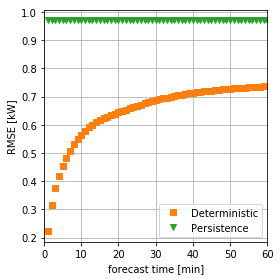

In [37]:
%%time
ts_p = ts.resample(resolution).mean().shift(steps)
deterministic_results(ts.resample(resolution).mean(), ts_st, ts_p, 'det1', x_factor=1, x_label='forecast time [min]')

10
20
30
40
50
60
CRPS_p:  0.604266 - 0.604266 - 0.604266
CRPS_d:  0.089172 - 0.422035 - 0.509769
CRPS_q:  0.075722 - 0.310664 - 0.365312
CPU times: user 22.9 s, sys: 12.9 s, total: 35.8 s
Wall time: 36.1 s


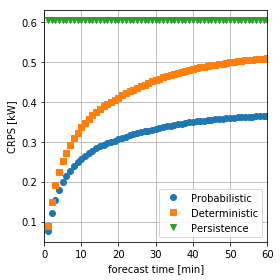

In [38]:
%%time
probabilistic_results_mean(ts.resample(resolution).mean(), ts_st, ts_p, 'prob1', frac=0.1, x_factor=1, x_label='forecast time [min]')

In [39]:
%%time
t0 = pd.Timestamp('2010-5-26 19:15:00')
#t0 = pd.Timestamp('2009-5-27 19:00:00')
y_st = short_term_single(ts.resample(resolution).mean()[:t0], rf, lr, lookback, steps)

CPU times: user 98.9 ms, sys: 36.1 ms, total: 135 ms
Wall time: 301 ms


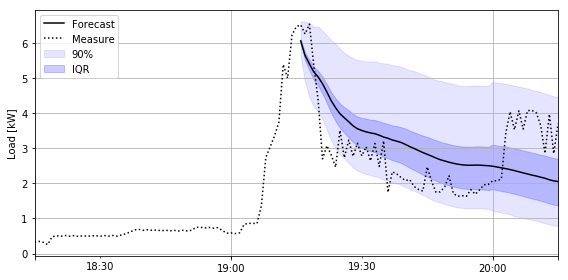

In [40]:
probabilistic_results_time(ts.resample(resolution).mean(), ts_st, y_st, 
                           t0, lookback, steps, name='ts_1', frac=0.1)

In [41]:
%%time
resolution = '15min'
lookback = 4*24
steps = 4*24

rf = long_term_fit(ts.resample(resolution).mean())
ts_lt = long_term_predict(ts.resample(resolution).mean().index, rf)
lr = short_term_fit(ts.resample(resolution).mean(), ts_lt, lookback, steps)

Find optimal tree depth...
Depth: 8
Depth: 9
Depth: 10
MAX_DEPTH: 9 - RMSE_VAL 0.769681
Fit random forest...
RMSE_TRAIN: 0.762940 - RMSE_TEST 0.716359
Fit Linear regression...
CPU times: user 16 s, sys: 489 ms, total: 16.4 s
Wall time: 7.19 s


In [42]:
%%time
ts_st = short_term_predict(ts.resample(resolution).mean(), ts_lt, lr, lookback, steps)

Predict linear regression...
CPU times: user 1.28 s, sys: 357 ms, total: 1.64 s
Wall time: 1.5 s


MAE p:  0.647549
MAPE p:  86.872284
RMSE p: 0.974352

MAE:  0.294614 - 0.510122 - 0.514084
MAPE: 39.816597 - 79.201127 - 80.064166
RMSE: 0.469768 - 0.704216 - 0.711160
SS:   0.517866 - 0.277248 - 0.270121
CPU times: user 579 ms, sys: 32 ms, total: 611 ms
Wall time: 654 ms


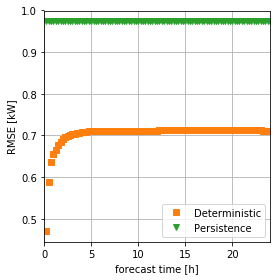

In [43]:
%%time
ts_p = ts.resample(resolution).mean().shift(steps)
deterministic_results(ts.resample(resolution).mean(), ts_st, ts_p, 'det2', x_factor=0.25, x_label='forecast time [h]')

10
20
30
40
50
60
70
80
90
CRPS_p:  0.647549 - 0.647549 - 0.647549
CRPS_d:  0.294614 - 0.510122 - 0.514084
CRPS_q:  0.223717 - 0.358456 - 0.361013
CPU times: user 21.2 s, sys: 12.1 s, total: 33.3 s
Wall time: 33.4 s


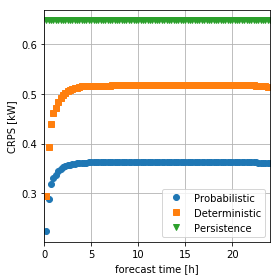

In [44]:
%%time
probabilistic_results_mean(ts.resample(resolution).mean(), ts_st, ts_p, 'prob2', x_factor=0.25, x_label='forecast time [h]')

In [45]:
%%time
t0 = pd.Timestamp('2010-5-26 19:15:00')
y_st = short_term_single(ts.resample(resolution).mean()[:t0], rf, lr, lookback, steps)

CPU times: user 63.5 ms, sys: 19.7 ms, total: 83.1 ms
Wall time: 255 ms


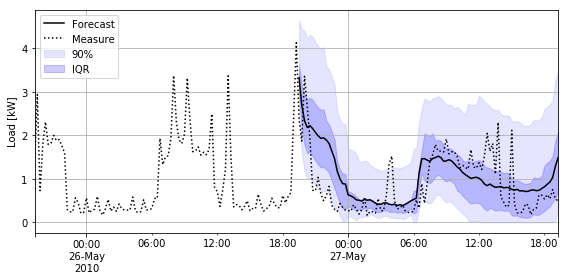

In [46]:
probabilistic_results_time(ts.resample(resolution).mean(), ts_st, y_st, 
                           t0, lookback, steps, name='ts_2')

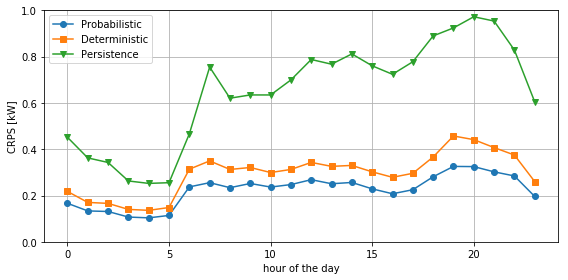

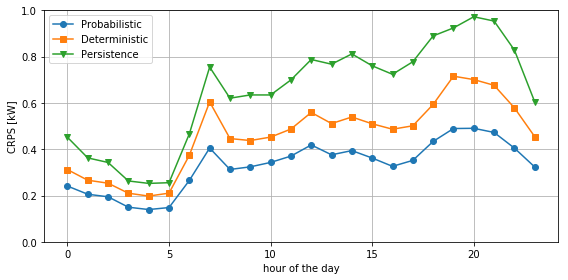

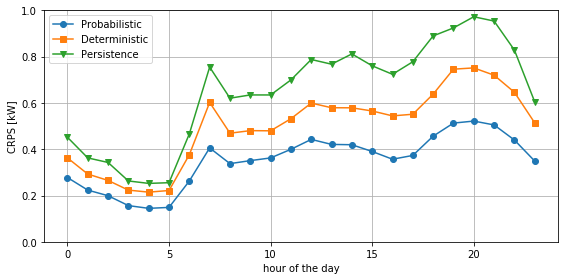

In [47]:
probabilistic_results_hourly(ts.resample(resolution).mean(), ts_st, ts_p, '15min', s=1)
probabilistic_results_hourly(ts.resample(resolution).mean(), ts_st, ts_p, '1h', s=4)
probabilistic_results_hourly(ts.resample(resolution).mean(), ts_st, ts_p, '2h', s=8)

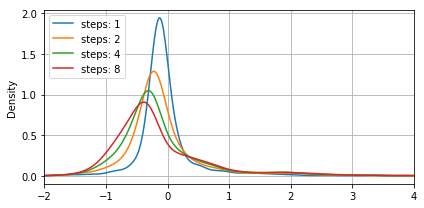

In [48]:
probabilistic_results_hist(ts, ts_st, h=16)


In [49]:
%%time
resolution = '1h'
lookback = 24*7
steps = 24*7

rf = long_term_fit(ts.resample(resolution).mean())
ts_lt = long_term_predict(ts.resample(resolution).mean().index, rf)
lr = short_term_fit(ts.resample(resolution).mean(), ts_lt, lookback, steps)

Find optimal tree depth...
Depth: 8
Depth: 9
Depth: 10
MAX_DEPTH: 9 - RMSE_VAL 0.650689
Fit random forest...
RMSE_TRAIN: 0.641363 - RMSE_TEST 0.608053
Fit Linear regression...
CPU times: user 4.87 s, sys: 273 ms, total: 5.14 s
Wall time: 3.2 s


In [50]:
%%time
ts_st = short_term_predict(ts.resample(resolution).mean(), ts_lt, lr, lookback, steps)

Predict linear regression...
CPU times: user 797 ms, sys: 147 ms, total: 945 ms
Wall time: 883 ms


MAE p:  0.553963
MAPE p:  70.911730
RMSE p: 0.815125

MAE:  0.356428 - 0.447565 - 0.451230
MAPE: 46.456519 - 62.998008 - 63.913247
RMSE: 0.498502 - 0.604048 - 0.607138
SS:   0.388435 - 0.258950 - 0.255159
CPU times: user 623 ms, sys: 24.5 ms, total: 647 ms
Wall time: 681 ms


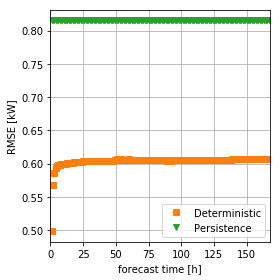

In [51]:
%%time
ts_p = ts.resample(resolution).mean().shift(steps)
deterministic_results(ts.resample(resolution).mean(), ts_st, ts_p, 'det3', x_factor=1, x_label='forecast time [h]')

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
CRPS_p:  0.553963 - 0.553963 - 0.553963
CRPS_d:  0.356428 - 0.447565 - 0.451230
CRPS_q:  0.258034 - 0.316448 - 0.318095
CPU times: user 11.6 s, sys: 5.28 s, total: 16.9 s
Wall time: 16.9 s


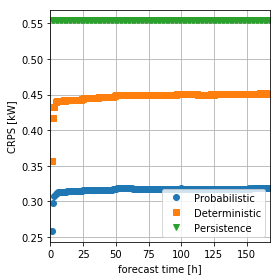

In [52]:
%%time
probabilistic_results_mean(ts.resample(resolution).mean(), ts_st, ts_p, 'prob3', x_factor=1, x_label='forecast time [h]')

In [53]:
%%time
t0 = pd.Timestamp('2010-5-26 19:15:00')
y_st = short_term_single(ts.resample(resolution).mean()[:t0], rf, lr, lookback, steps)

CPU times: user 58 ms, sys: 11.6 ms, total: 69.6 ms
Wall time: 241 ms


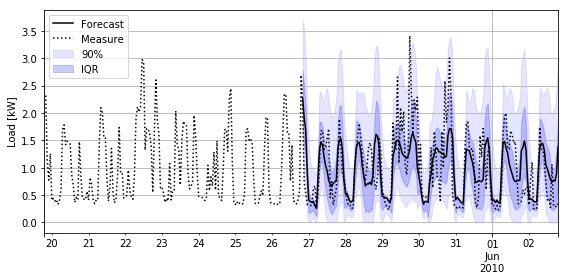

In [54]:
probabilistic_results_time(ts.resample(resolution).mean(), ts_st, y_st, 
                           t0, lookback, steps, name='ts_3')

In [55]:
%%time
rf_resolution = '7d'

y_rf = ts.resample(rf_resolution).mean()

year = y_rf.index.year.to_series(name='year', index=y_rf.index)
dayofyear = y_rf.index.dayofyear.to_series(name='dayofyear', index=y_rf.index)
month = y_rf.index.month.to_series(name='month', index=y_rf.index)
weekofyear = y_rf.index.weekofyear.to_series(name='weekofyear', index=y_rf.index)
dayofweek = y_rf.index.dayofweek.to_series(name='dayofweek', index=y_rf.index)
hour = y_rf.index.hour.to_series(name='hour', index=y_rf.index)
minute = y_rf.index.minute.to_series(name='minute', index=y_rf.index)
time = hour + minute / 60.
time.name = 'hour'

X_rf = pd.concat([year, month, weekofyear], axis=1)

print('Find optimal tree depth...')
depth = 0
rmse_val = np.inf
for d in range(3, 10):
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True, 
                               max_features='sqrt', max_depth=d, random_state=42)
    rf.fit(X_rf[:train_date], y_rf[:train_date])
    rmse = root_mean_squared_error(rf.predict(X_rf[train_date:test_date]), 
                                   y_rf[train_date:test_date])
    if (rmse < rmse_val):
        rmse_val = rmse
        depth = d
print('MAX_DEPTH: %d - RMSE_VAL %f' %(depth, rmse_val))

print('Fit random forest...')
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True, 
                           max_features='sqrt', max_depth=depth, random_state=42)
rf.fit(X_rf[:test_date], y_rf[:test_date])

rmse_train = root_mean_squared_error(rf.predict(X_rf[:test_date]), y_rf[:test_date])
rmse_test = root_mean_squared_error(rf.predict(X_rf[test_date:]), y_rf[test_date:])
print('RMSE_TRAIN: %f - RMSE_TEST %f' %(rmse_train, rmse_test))

Find optimal tree depth...
MAX_DEPTH: 5 - RMSE_VAL 0.142485
Fit random forest...
RMSE_TRAIN: 0.157969 - RMSE_TEST 0.144895
CPU times: user 1.09 s, sys: 258 ms, total: 1.35 s
Wall time: 2.39 s


In [56]:
%%time
ts_rf = pd.Series(rf.predict(X_rf), index=y_rf.index)

print('MAE p:  %f'%(mean_absolute_error(y_rf[test_date:], y_rf.shift(52)[test_date:])))
print('MAPE p:  %f'%(mean_average_percentage_error(y_rf[test_date:], y_rf.shift(52)[test_date:])))
print('RMSE p: %f'%(np.sqrt(mean_squared_error(y_rf[test_date:], y_rf.shift(52)[test_date:]))))

print()

print('MAE:  %f'%(mean_absolute_error(y_rf[test_date:], ts_rf[test_date:])))
print('MAPE: %f'%(mean_average_percentage_error(y_rf[test_date:], ts_rf[test_date:])))
print('RMSE: %f'%(np.sqrt(mean_squared_error(y_rf[test_date:], ts_rf[test_date:]))))
print('SS:   %f'%(1.  - np.sqrt(mean_squared_error(y_rf[test_date:], ts_rf[test_date:])) / 
                        np.sqrt(mean_squared_error(y_rf[test_date:], y_rf.shift(52)[test_date:]))))

print()

print('CRPS_p: %f'%(ps.crps_ensemble(y_rf[test_date:], y_rf.shift(52)[test_date:]).mean()))
print('CRPS_d: %f'%(ps.crps_ensemble(y_rf[test_date:], ts_rf[test_date:]).mean()))



MAE p:  0.119511
MAPE p:  13.618570
RMSE p: 0.164877

MAE:  0.114164
MAPE: 14.186226
RMSE: 0.144895
SS:   0.121193

CRPS_p: 0.119511
CRPS_d: 0.114164
CPU times: user 25.2 ms, sys: 5.7 ms, total: 30.9 ms
Wall time: 112 ms


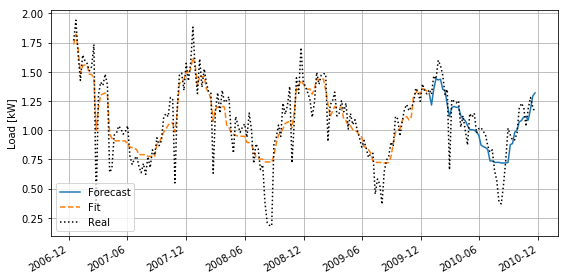

In [57]:
plt.figure(figsize=(8,4))
ts_rf[test_date-pd.Timedelta('7 days'):].plot(label='Forecast', color='tab:blue', linestyle='solid')
ts_rf[:test_date].plot(label='Fit', color='tab:orange', linestyle='dashed')
y_rf.plot(label='Real', color='k', linestyle='dotted')
plt.ylabel('Load [kW]')
#plt.xlabel('time')
plt.xlabel('')
plt.grid(True)
plt.tight_layout()
plt.legend(loc='lower left')
plt.savefig('weekly_forecast.png', dpi=300)

In [58]:
print(len(ts_rf[:test_date]), len(ts_rf[test_date:]))

159 47


In [59]:
import holidays

In [60]:
hd = holidays.France

In [61]:
hd

holidays.France

In [62]:
for date, name in sorted(holidays.France(years=[2007, 2008, 2009, 2010]).items()):
    print(date, name)

2007-01-01 Jour de l'an
2007-04-09 Lundi de Pâques
2007-05-01 Fête du Travail
2007-05-08 Armistice 1945
2007-05-17 Ascension
2007-05-28 Lundi de Pentecôte
2007-07-14 Fête nationale
2007-08-15 Assomption
2007-11-01 Toussaint
2007-11-11 Armistice 1918
2007-12-25 Noël
2008-01-01 Jour de l'an
2008-03-24 Lundi de Pâques
2008-05-01 Ascension, Fête du Travail
2008-05-08 Armistice 1945
2008-05-12 Lundi de Pentecôte
2008-07-14 Fête nationale
2008-08-15 Assomption
2008-11-01 Toussaint
2008-11-11 Armistice 1918
2008-12-25 Noël
2009-01-01 Jour de l'an
2009-04-13 Lundi de Pâques
2009-05-01 Fête du Travail
2009-05-08 Armistice 1945
2009-05-21 Ascension
2009-06-01 Lundi de Pentecôte
2009-07-14 Fête nationale
2009-08-15 Assomption
2009-11-01 Toussaint
2009-11-11 Armistice 1918
2009-12-25 Noël
2010-01-01 Jour de l'an
2010-04-05 Lundi de Pâques
2010-05-01 Fête du Travail
2010-05-08 Armistice 1945
2010-05-13 Ascension
2010-05-24 Lundi de Pentecôte
2010-07-14 Fête nationale
2010-08-15 Assomption
2010-11-0

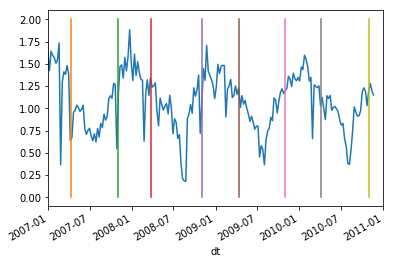

In [63]:
y_rf.plot()
plt.xlim('2007', '2011')
plt.plot((pd.Timestamp('2007-04-09'), pd.Timestamp('2007-04-09')), (0,2))
plt.plot((pd.Timestamp('2007-11-01'), pd.Timestamp('2007-11-01')), (0,2))
plt.plot((pd.Timestamp('2008-03-24'), pd.Timestamp('2008-03-24')), (0,2))
plt.plot((pd.Timestamp('2008-11-01'), pd.Timestamp('2008-11-01')), (0,2))
plt.plot((pd.Timestamp('2009-04-13'), pd.Timestamp('2009-04-13')), (0,2))
plt.plot((pd.Timestamp('2009-11-01'), pd.Timestamp('2009-11-01')), (0,2))
plt.plot((pd.Timestamp('2010-04-05'), pd.Timestamp('2010-04-05')), (0,2))
plt.plot((pd.Timestamp('2010-11-01'), pd.Timestamp('2010-11-01')), (0,2))